In [20]:
library(wbstats) #to load data from World Bank
library(DT) #to transform the data
library(ggplot2) #to visualize the data
library(dplyr) #to transform the data
library(readr) #to read csv
library(corrplot) #to build correlation plot
library(countrycode) #to match country name with country code
library(ggthemes) #theme for graphics
library(visdat) #to visualize NA
library(ggrepel) #to visualize country names
#cannot install due to permission right
# library(plotly) #to create interactive graphs
library(olsrr) # to check linear regression assumptions

Warning message:
"package 'olsrr' was built under R version 3.6.3"
Attaching package: 'olsrr'

The following object is masked from 'package:datasets':

    rivers



In [19]:
#install pcakages
wd = "C:/Users/JiunShyanGoh/anaconda3/envs/r-Env/Lib/R/library"
packageName = "olsrr"
install.packages(packageName, wd)

also installing the dependencies 'Rcpp', 'matrixStats', 'RcppArmadillo', 'zip', 'SparseM', 'MatrixModels', 'conquer', 'sp', 'openxlsx', 'minqa', 'nloptr', 'RcppEigen', 'carData', 'abind', 'pbkrtest', 'quantreg', 'maptools', 'rio', 'lme4', 'car', 'goftest', 'gridExtra', 'nortest'




  There are binary versions available but the source versions are later:
                  binary     source needs_compilation
Rcpp               1.0.6      1.0.7              TRUE
matrixStats       0.58.0     0.60.1              TRUE
RcppArmadillo 0.10.4.0.0 0.10.6.0.0              TRUE
zip                2.1.1      2.2.0              TRUE
openxlsx           4.2.3      4.2.4              TRUE
quantreg            5.85       5.86              TRUE
maptools           1.1-1      1.1-2              TRUE
rio               0.5.26     0.5.27             FALSE
lme4              1.1-26   1.1-27.1              TRUE
car               3.0-10     3.0-11             FALSE

  Binaries will be installed
package 'Rcpp' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'Rcpp'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\JiunShyanGoh\anaconda3\envs\r-Env\Lib\R\library\00LOCK\Rcpp\libs\x64\Rcpp.dll to C:\Users\JiunShyanGoh\anaconda3\envs\r-Env\Lib\R\library\Rcpp\libs\x64\Rcpp.dll: Permission denied"Warning message:
"restored 'Rcpp'"

package 'matrixStats' successfully unpacked and MD5 sums checked
package 'RcppArmadillo' successfully unpacked and MD5 sums checked
package 'zip' successfully unpacked and MD5 sums checked
package 'SparseM' successfully unpacked and MD5 sums checked
package 'MatrixModels' successfully unpacked and MD5 sums checked
package 'conquer' successfully unpacked and MD5 sums checked
package 'sp' successfully unpacked and MD5 sums checked
package 'openxlsx' successfully unpacked and MD5 sums checked
package 'minqa' successfully unpacked and MD5 sums checked
package 'nloptr' successfully unpacked and MD5 sums checked
package 'RcppEigen' successfully unpacked and MD5 sums checked
package 'carData' successfully unpacked and MD5 sums checked
package 'abind' successfully unpacked and MD5 sums checked
package 'pbkrtest' successfully unpacked and MD5 sums checked
package 'quantreg' successfully unpacked and MD5 sums checked
package 'maptools' successfully unpacked and MD5 sums checked
package 'lme4' su

installing the source packages 'rio', 'car'



### Load data - 2015

In [23]:
#load data
filename <- "Data/world-happiness-report.csv"
world_happiness <- read_csv(filename, col_types = cols())

#rename columrn
colnames(world_happiness)[1]<-"country"

#filter only 2015 from WHI
world_happiness_2015<-world_happiness %>% 
  filter(year == "2015")

#match iso3c with country name
world_happiness_2015$iso3c<-countrycode(world_happiness_2015$country, 'country.name', 'iso3c')

#load data about alcohol consumption (2015) from World Bank
#using library wbstats
d_2015 <- wb(indicator = "SH.ALC.PCAP.LI",
        startdate = 2015, enddate = 2015)
#round alcohol consumption value (3 digits)
d_2015$value <- round(d_2015$value, digits = 3)

#load data that contains country codes, region, sub-region, level of development
filename <- "Data/region.csv"
code <- read_csv(filename, na = "empty", col_types = cols())
#select only needed columns
code<-code %>% 
  select(Region_Name,Sub_region_Name,Country_or_Area, iso3c, dev)

### Processing

In [38]:
#join WHI with alcohol consumption by iso3c
happiness_alc_2015<-world_happiness_2015 %>% 
               left_join(d_2015, by = "iso3c")
#join WHI, alcohol consumption with regions, sub-regions, 
#level of development by iso3c
happiness_alc_2015<-happiness_alc_2015 %>% 
  left_join(code, by = "iso3c")

#rename columns
colnames(happiness_alc_2015)<- c("country", "year", "life_ladder", 
                            "log_gdp_cap", "social_support","life_expect", "freedom", 
                            "generosity", "corruption", "pos_aff", 
                            "neg_aff", "iso3c", "date", "alc", 
                            "indicator_id", "indicator", "iso2c", "country.y", "region", 
                            "sub_region", 'country_name', 'dev')
#select only needed columns
happiness_alc_2015<-happiness_alc_2015 %>% 
              select(-iso2c,-date, -indicator_id, -indicator, -country_name, -country.y)

### Correlation

In [42]:
#select only numeric data to build correlation plot
happiness_alc_num_2015<-happiness_alc_2015 %>% 
                  select(-country, -year, -region, -sub_region, -iso3c, -region, -sub_region, -dev)
#happiness_alc_2015 %>% dplyr::select(where(is.numeric), -year)
#delete all rows with NA
happiness_alc_num_2015<-na.omit(happiness_alc_num_2015)

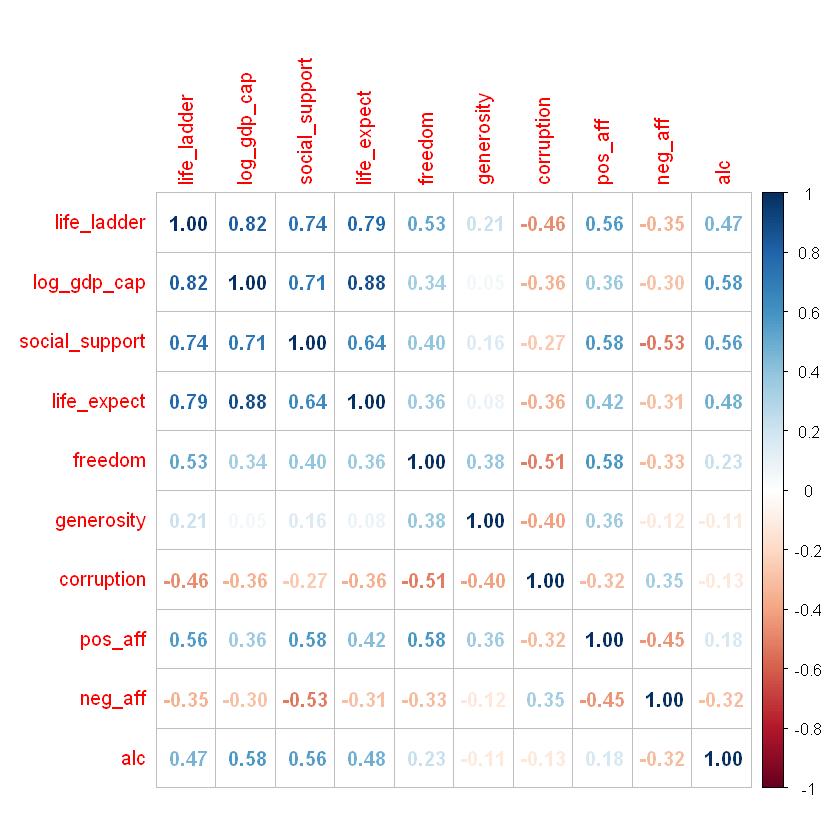

In [44]:
M<-cor(happiness_alc_num_2015)
corrplot(M, method = "number")

no predictors are highly correlated to each other. We may not have multicollinearity problem

Warning message:
"Ignoring unknown aesthetics: text"Warning message:
"Removed 6 rows containing missing values (geom_point)."

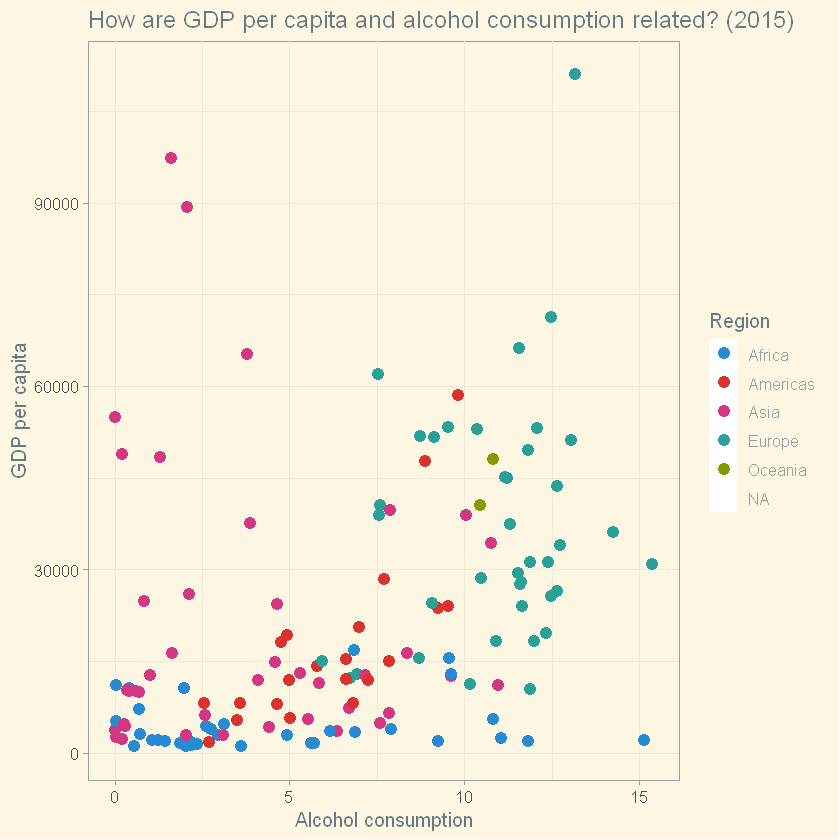

In [47]:
# alcohol consumption and  gdp per capita (color region)
fig<-ggplot(happiness_alc_2015)+
  geom_point(aes(alc, exp(log_gdp_cap), col = region,
                 text = paste("Alcohol consumption:", paste(happiness_alc_2015$alc, "liters"), "<br>",
                              "GDP per capita:", paste0("$", round(exp(happiness_alc_2015$log_gdp_cap), 2)), "<br>",
                              "Country:", happiness_alc_2015$country, "<br>",
                              "Region:", happiness_alc_2015$region)),
            size = 3)+
  labs(x = "Alcohol consumption", y = "GDP per capita", 
       title = "How are GDP per capita and alcohol consumption related? (2015)",
       colour = "Region")+
  theme_solarized()+
  scale_colour_solarized() 
fig

Europe countries have more data points which skew towards high alcohol consumption compared to other region

Warning message:
"Removed 6 rows containing missing values (geom_point)."

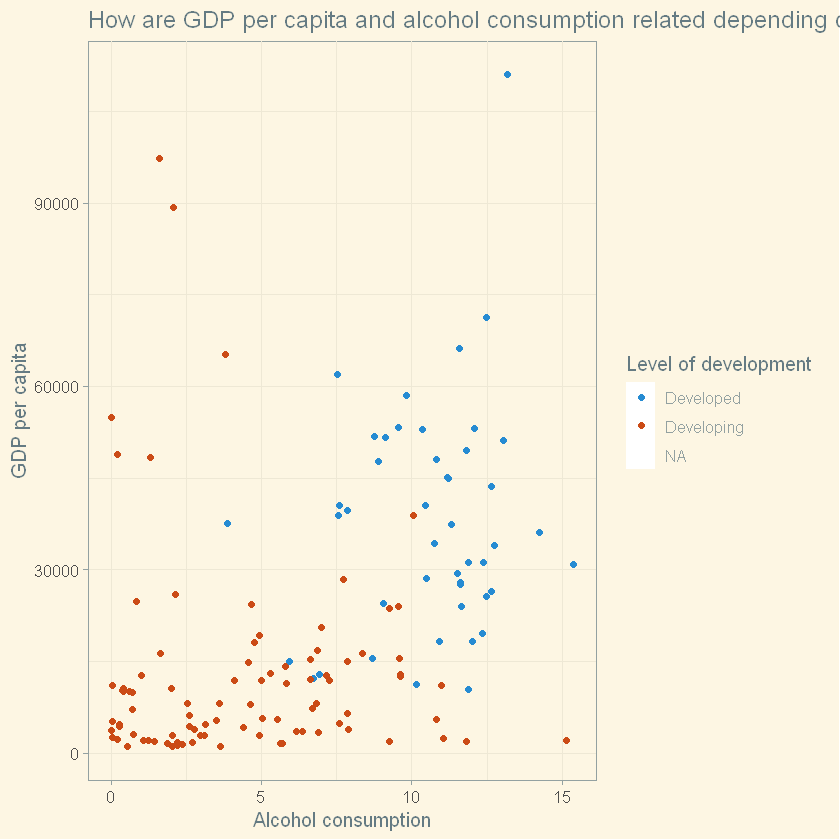

In [48]:
# alcohol consumption and  gdp per capita (color developed or developing)
ggplot(happiness_alc_2015, aes(alc, exp(log_gdp_cap), col = dev, label = iso3c))+
  geom_point()+
  labs(x = "Alcohol consumption", y = "GDP per capita", 
       title = "How are GDP per capita and alcohol consumption related depending on the level of development of the country? (2015)",
       colour = "Level of development")+
  theme_solarized()+
  scale_colour_solarized()

In [53]:
# linear model: predicted is life_expect 
# explanatory variables:log_gdp_cap,   alcohol consumption (2015)
fit<-lm(life_expect~log_gdp_cap + alc,happiness_alc_2015 )
summary(fit)


Call:
lm(formula = life_expect ~ log_gdp_cap + alc, data = happiness_alc_2015)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.7321  -1.9917   0.4764   2.4065   7.0958 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 15.99137    2.57341   6.214 6.08e-09 ***
log_gdp_cap  5.04775    0.29358  17.194  < 2e-16 ***
alc          0.06979    0.08099   0.862     0.39    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.558 on 134 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.7475,	Adjusted R-squared:  0.7437 
F-statistic: 198.4 on 2 and 134 DF,  p-value: < 2.2e-16


We build a linear model with log of gdp per capita and alcohol consumption from year 2015 as predictors to predict life_expect.
From results, our linear equation: life_expect = 5.04*log_gdp_cap + 0.06979*alc + 15.99

In [ ]:
H0: Coefficient = 0 or there is no relationship
H1: Coefficient!=0 or there is a relationship

This model is not statistically significant unless Both predictors have to reject H0 (pvalue < 0.05)
Judging from p-value, log_gdp_cap has significant relationship with life_expect at significant level of 0.001

In [ ]:
R-squared - proportion of variation in dependent variable that is explained by this model

R2 = 1 -(RSS/TSS)

RSS - Residual Sum of Squares : (y-y^)^2
TSS - Sum of Squared Total : (y-ybar)^2

In [ ]:
adjusted R-squared - penalses number of predictors put as variation will increase as number of predictors increases

adjusted R2 = 1 - (MSE/MST)

MSE - mean squared error : (RSS/n-q), n - number of observation, q - number of coefficients

In [ ]:
T-statistic: shud be graeater than 1.96 for p-value to be less than 0.05

In [ ]:
Standard error (the less the better) - measure of goodness of fit

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.966          0.0017 
Kolmogorov-Smirnov        0.078          0.3754 
Cramer-von Mises          7.7855         0.0000 
Anderson-Darling          1.132          0.0056 
-----------------------------------------------

[1] 0.9827703

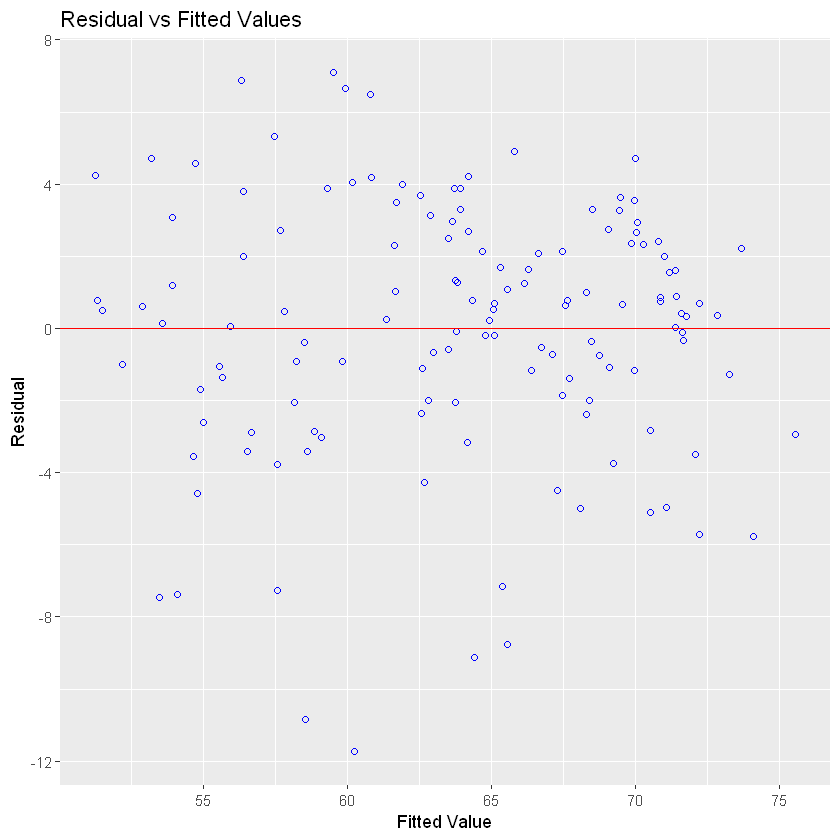

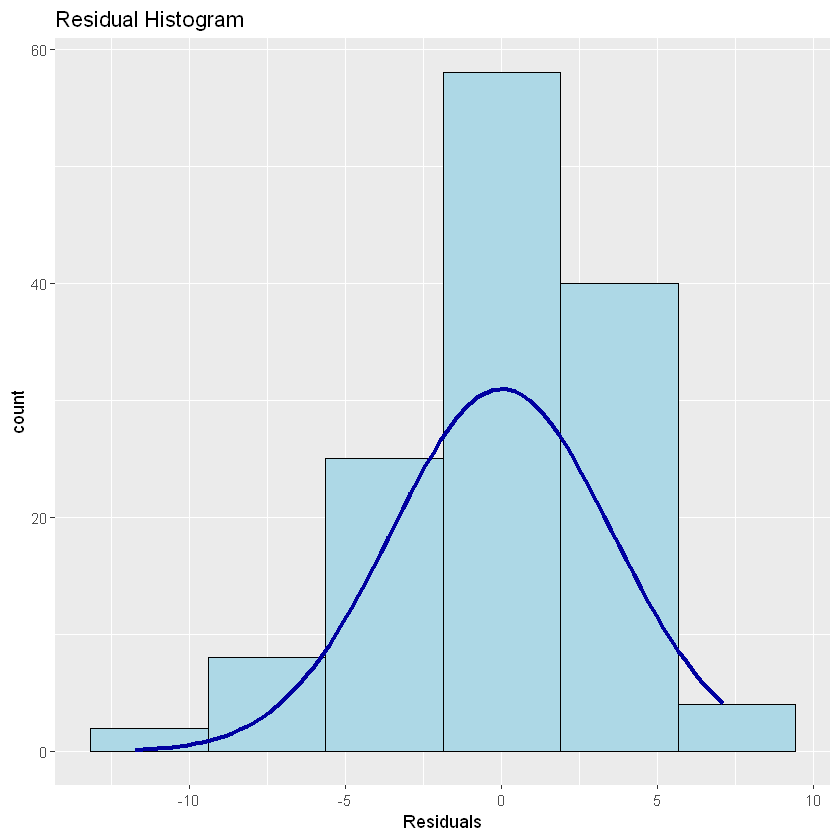

In [54]:
ols_test_normality(fit)
ols_test_correlation(fit)
ols_plot_resid_fit(fit)
ols_plot_resid_hist(fit)

In [ ]:
source: https://stats.stackexchange.com/questions/362/what-is-the-difference-between-the-shapiro-wilk-test-of-normality-and-the-kolmog
Shapiro-Wilk (unspecified mean and variance) - more powerful
Kolmogorov-Smirnov (specified mean and variance) - less powerful, less often to correctly rejects null hypothesis
H0: normally distributed
H1: Not normally distributed

H0: pvalue > 0.05, accept H0, normally distributed

In [ ]:
https://statisticsbyjim.com/regression/check-residual-plots-regression-analysis/
residual plot
residual should be random so that model is valid (else cannot trust coefficients)
regression assumes residuals follow normal distribution